#**Problem Statement**
The anthropometric analysis of the human face is an essential study for performing craniofacial plastic and reconstructive surgeries. Facial anthropometrics are affected by various factors such as age, gender, ethnicity, socioeconomic status, environment, and region.  

 
Plastic surgeons who undertake the repair and reconstruction of facial deformities find the anatomical dimensions of the facial structures useful for their surgeries. These dimensions are a result of the Physical or Facial appearance of an individual. Along with factors like culture, personality, ethnic background, age; eye appearance and symmetry contributes majorly to the facial appearance or aesthetics. 

 

Our objective is to build a model to scan the image of an eye of a patient and find if the gender of the patient is male or female.

 The dataset contains eye pictures of males and females. The dataset can be downloaded from the below link.

 

Dataset Link: https://drive.google.com/file/d/1f7uslI-ZHidriQFZR966_aILjlkgDN76/view?usp=sharing

From the above link, you will be able to download a zip file named ‘eye_gender_data.zip’. After you extract this zip file, you will get four files:

1. train - contains all the images that are to be used for training your model.

2. Training_set.csv - this csv file has contains the labels for the training images

3. test - contains 9000+ images. For these images you are required to make predictions

4. Testing_set.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you submit are with their image’s filename in the same order as given in this file.


## **Import Important**

In [23]:
# to prevent unnecessary warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# TensorFlow and tf.keras
import tensorflow as tf

from pathlib import Path

#import useful module for keras library
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# get modules from sklearn library
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 

#import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np

## **Import Dataset**

Load the training set data

In [4]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = '/content/drive/MyDrive/eye_gender_data/'

#read the train_data with pandas read csv
eye_train = pd.read_csv(path+"Training_set.csv")
eye_test = pd.read_csv(path+"Testing_set.csv")


#view the first 4 rows of the dataset in a table
eye_train.head()

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


In [6]:
#get shape of dataset
print(eye_train.shape)

print(eye_train.info())

(9220, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9220 entries, 0 to 9219
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  9220 non-null   object
 1   label     9220 non-null   object
dtypes: object(2)
memory usage: 144.2+ KB
None


In [7]:
eye_train['label'].unique()

array(['male', 'female'], dtype=object)

In [8]:
#get the counts of the labels
eye_train['label'].value_counts()

male      5058
female    4162
Name: label, dtype: int64

In [9]:
# There is a different dataset for testing,
#we split the train dataset into train and validation set

train_set, val_set = train_test_split(eye_train, test_size = 0.3, random_state = 42)

print(train_set.shape)
print(val_set.shape)

(6454, 2)
(2766, 2)


### **Image preprocessing and generation**


In [10]:
img_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input, 
                             rescale=1/255, zoom_range = 0.2,
                                rotation_range = 20,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                horizontal_flip = True)

# img_gen cannot take in an array, so ensure the data that is been passed is a dataframe
train = img_gen.flow_from_dataframe(dataframe = train_set,
    directory = '/content/drive/MyDrive/eye_gender_data/train' ,  # the path contaning the images                                 
    x_col = 'filename', #name of the column containing the image in the train set
    y_col ='label', #name of column containing the target in the train set
    target_size = (100, 100),
    color_mode = 'rgb',
    class_mode = 'categorical',#the class mode here and that for the model_loss(when using sequential model)
                                    #should be the same
    batch_size = 32,
    shuffle = False #not to shuffle the given data
)

val = img_gen.flow_from_dataframe(dataframe = val_set,
    directory = '/content/drive/MyDrive/eye_gender_data/train' ,   # the path conataining the images                          
    x_col = 'filename', #name of the column containing the image in the test set
    y_col ='label', #name of column containing the target in the test set
    target_size =(100, 100),
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = 32,
    shuffle = False # not to shuffle the given data
)

Found 6454 validated image filenames belonging to 2 classes.
Found 2766 validated image filenames belonging to 2 classes.


## **Model Building**

In [11]:
# define sequential model
model = tf.keras.models.Sequential()
# define conv-pool layers - set 1
model.add(tf.keras.layers.Conv2D(filters = 32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape = (100, 100, 3)))
model.add(BatchNormalization(axis=3))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# define conv-pool layers - set 2
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# define conv-pool layers - set 3
model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


# add flatten layer
model.add(tf.keras.layers.Flatten())

# add dense layers with some dropout
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.2))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))

# add output layer
model.add(tf.keras.layers.Dense(2, kernel_regularizer = l2(0.01), #adding regularizer for svm, Because when we use Support Vector Machine for binary classification we use something called LinearSVM
                                activation='linear')) #use softmax as activation in the output layer
#for multiclass. Sigmoid activation is used for binary and 'relu' shouldnt be use for output layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 16)       0         
 2D)                                                             
                                                        

In [12]:
#import modules that will wnable early stopping for optimization during model training
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from datetime import datetime

#tensorboard
logdir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

#define the early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [13]:
# compile model
model.compile(optimizer='adam', # optimize the model with adam optimizer
              loss="hinge", #for svm classification
              metrics=['accuracy']) #to get accuracy of the model in each run

In [14]:
#fit the model on train data and add val data fro validation
history = model.fit(train,
    batch_size = 32,
    verbose = 1, # Suppress chatty output; use Tensorboard instead
    epochs = 50,
    validation_data = val, #add the validation set to evaluate the performance in each run
    callbacks = [tensorboard_callback, es],
)

Epoch 1/50
202/202 [==============================] - 1691s 8s/step - loss: 0.9085 - accuracy: 0.5731 - val_loss: 0.9067 - val_accuracy: 0.5510
Epoch 2/50
202/202 [==============================] - 144s 711ms/step - loss: 0.7657 - accuracy: 0.6522 - val_loss: 0.8167 - val_accuracy: 0.6493
Epoch 3/50
202/202 [==============================] - 167s 826ms/step - loss: 0.7050 - accuracy: 0.6700 - val_loss: 0.8950 - val_accuracy: 0.5712
Epoch 4/50
202/202 [==============================] - 161s 798ms/step - loss: 0.6728 - accuracy: 0.6774 - val_loss: 0.8844 - val_accuracy: 0.5879
Epoch 5/50
202/202 [==============================] - 161s 798ms/step - loss: 0.6507 - accuracy: 0.6887 - val_loss: 0.8046 - val_accuracy: 0.6164
Epoch 6/50
202/202 [==============================] - 161s 795ms/step - loss: 0.6116 - accuracy: 0.7067 - val_loss: 0.6615 - val_accuracy: 0.6782
Epoch 7/50
202/202 [==============================] - 161s 795ms/step - loss: 0.5843 - accuracy: 0.7183 - val_loss: 0.9088 - v

Text(0.5, 1.0, 'Training and Validation Accuracy')

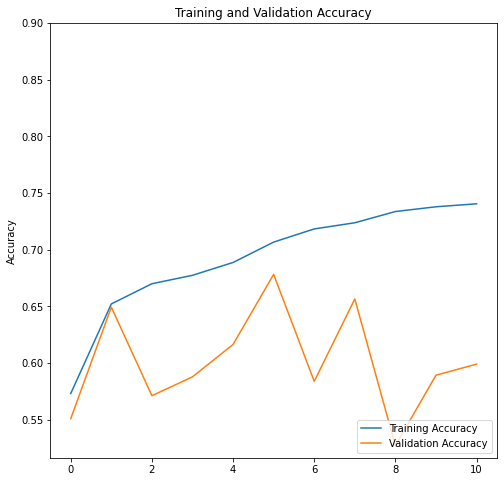

In [15]:
acc = history.history['accuracy'] # get history report of the model

val_acc = history.history['val_accuracy'] # get history of the validation set

loss = history.history['loss'] #get the history of the lossses recorded on the train set
val_loss = history.history['val_loss'] #get the history of the lossses recorded on the validation set

plt.figure(figsize=(8, 8)) # set figure size for the plot generated


plt.plot(acc, label='Training Accuracy') #plot accuracy curve for each train run
plt.plot(val_acc, label='Validation Accuracy') #plot accuracy curve for each validation run

plt.legend(loc='lower right')
plt.ylabel('Accuracy') #label name for y axis
plt.ylim([min(plt.ylim()),0.9]) #set limit for y axis
plt.title('Training and Validation Accuracy') #set title for the plot

(0.5167595833539963, 1.0)

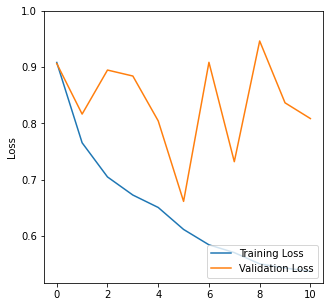

In [16]:
plt.figure(figsize=(5, 5)) # set figure size for the plot generated


plt.plot(loss, label='Training Loss') #plot loss curve for each train run
plt.plot(val_loss, label='Validation Loss') #plot loss curve for each validation run

plt.legend(loc='lower right')
plt.ylabel('Loss') #label name for y axis
plt.ylim([min(plt.ylim()), 1]) #set limit for y axis

In [17]:

imgen = ImageDataGenerator(rescale=1/255 )

# img_gen cannot take in an array, so ensure the data that is been passed is a dataframe
test = imgen.flow_from_dataframe(dataframe = eye_test,
    directory = '/content/drive/MyDrive/eye_gender_data/test' ,  # the path contaning the images                                 
    target_size = (100, 100),
    color_mode = 'rgb',
    class_mode= None ,#the class mode here and that for the model_loss(when using sequential model)
                                    #should be the same
    batch_size = 32,
    shuffle = False #not to shuffle the given data
)



Found 2305 validated image filenames.


## **Prediction**

In [33]:
prediction = model.predict_generator(test, verbose=1)

<ipython-input-33-250f67c180f4>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  prediction = model.predict_generator(test, verbose=1)


73/73 [==============================] - 11s 152ms/step


In [34]:
len(prediction)

2305

In [35]:
prediction = np.argmax(prediction, axis = 1) # pick the class with highest probability


labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in prediction]


output = pd.DataFrame({'label': predictions})

In [36]:
output

,label
0,female
1,female
2,male
3,female
4,male
...,...
2300,female
2301,female
2302,female
2303,male
